# View fitted PCigale spectra


- Read parameters files (not the spectra file)

- Show nice plots for pressentations

- Author Sylvie Dagoret-Campagne
- Afflilation : IJCLab/IN2P3/CNRS
- Organisation : LSST-DESC
- creation date : 2024-02-08
  

In [1]:
import h5py
import pandas as pd
import numpy as np
import os
import re
import pickle 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import collections
from collections import OrderedDict
import re
import matplotlib.gridspec as gridspec

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_96948/2047720228.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  16

In [3]:
def calc_ratio(wl,spec, w_blue = [3750.,3950.], w_red = [4050.,4250] ):
    """Calculate the ratio of spectra in the wavelength range.


    :param wl: wavelength
    :type wl: array of float
    :param spec: spectrum in fnu
    :type spec: array of float
    :param w_blue: wavelength range in blue part of the spectrum
    :type w_blue: array of two floats, default to calculate D4000.
    :param w_red: wavelength range in red part of the spectrum
    :type w_red: array of two floats, default to calculate D4000.
    :return: the flux ratio red/blue
    :rtype: float
    """

    indexes_red = np.where(np.logical_and(wl>=w_red[0], wl<=w_red[1]))[0]
    indexes_blue = np.where(np.logical_and(wl>=w_blue[0], wl<=w_blue[1]))[0]
    int_spec_blue = np.trapz(spec[indexes_blue],wl[indexes_blue])
    int_spec_red = np.trapz(spec[indexes_red],wl[indexes_red])
    specratio = int_spec_red/int_spec_blue
    return specratio

In [4]:
D4000_red = [4050.,4250] 
D4000_blue = [3750.,3950.]

## imports

### fors2starlightio

In [5]:
from fors2pcigale.fors2starlightio import flux_norm

In [6]:
from sedpy import observate
from fors2pcigale.filters import FilterInfo

## Configuration

### fitted params

In [7]:
# current date

date = "2024-02-05"
# previous date
#date = "2023-11-27"
suptitle = f"SED-PCIGALES-fit (run {date})"

In [8]:
input_path = "./"
input_file = output_file_h5  = f"FittedSSPspectraPcigale_{date}.hdf5"

In [9]:
fullname_input = os.path.join(input_path ,input_file) 

In [10]:
Lyman_lines = [1220., 1030. ,973.,950., 938., 930.]
Balmer_lines = [6562.791,4861.351,4340.4721,4101.740,3970.072,3889.0641,3835.3971]
Paschen_lines = [8750., 12820., 10938.0,10050., 9546.2, 9229.7,9015.3, 8862.89,8750.46,8665.02]
Brackett_lines = [40522.79, 26258.71, 21661.178, 19440., 18179.21]
Pfund_lines = [ 74599.0, 46537.8, 37405.76 , 32969.8, 30400.]
all_Hydrogen_lines = [ Lyman_lines, Balmer_lines, Paschen_lines, Brackett_lines, Pfund_lines]
Color_lines = ["purple", "blue", "green", "red","grey"]
Balmer_thres = 3645.6
Lyman_thres = 911.267
Paschen_thres = 8200.
Brackett_thres = 14580.
Pfund_lines = 22800.
all_Hydrogen_thres = [Lyman_thres , Balmer_thres, Paschen_thres, Brackett_thres, Pfund_lines]

In [11]:
wl0 = 3645.6

In [12]:
D4000_red = [4050.,4250] 
D4000_blue = [3750.,3950.]
W_BALMER = [Balmer_thres, Balmer_lines[0]]
W_LYMAN = [Lyman_thres, Lyman_lines[0]]

In [13]:
def plot_hydrogen_lines(ax):
    nth = len(all_Hydrogen_thres)
    for idx,group_lines in enumerate(all_Hydrogen_lines):
        # select only Lyman and Balmer
        if idx<2:
            color = Color_lines[idx]
            for wl_line in group_lines:
                ax.axvline(wl_line,color=color,lw=0.5)
            if idx< nth:
                ax.axvline(all_Hydrogen_thres[idx],color=color,linestyle=":")
    ax.axvspan(W_LYMAN[0],W_LYMAN[1],facecolor='green', alpha=0.5)
    ax.axvspan(W_BALMER[0],W_BALMER[1],facecolor='yellow', alpha=0.5)

In [14]:
#title="redshifts for RXJ 0054.0-2823 : long_gal = 278.66° , lat_gal = -88.60°",ax=ax);

In [15]:
D4000MIN = 0.8
D4000MAX = 2.0

## Read hdf5 file

In [16]:
if os.path.isfile(input_file):
    hf = h5py.File(input_file, 'r')
    list_of_groupkeys = list(hf.keys())
    # pick one key
    key_sel =  list_of_groupkeys[0]
    # pick one group
    group = hf.get(key_sel)
    #pickup all attribute names
    list_of_subgroup_keys = []
    for k in group.attrs.keys():
        list_of_subgroup_keys.append(k)
else:
    hf = None
    list_of_groupkeys = []
    list_of_subgroup_keys = []

### Sort names

In [17]:
all_nums = []
list_of_groupkeys = np.array(list_of_groupkeys)
for key in list_of_groupkeys:
    num_str = re.findall("^SPEC(.+)",key)[0]
    all_nums.append(int(num_str)) 
all_nums = np.array(all_nums)

sorted_indexes = np.argsort(all_nums)
list_of_keys_sorted = list_of_groupkeys[np.argsort(all_nums)]

In [18]:
all_z = OrderedDict()
arr_z = []
for key_sel in list_of_keys_sorted:
    group = hf.get(key_sel)
    list_of_subgroup_keys = []
    for k in group.attrs.keys():
        list_of_subgroup_keys.append(k)
    redshift = group.attrs["redshift"]
    all_z[key_sel] = redshift
    arr_z.append(redshift) 
arr_z = np.array(arr_z)

Text(0.5, 1.0, 'redshift')

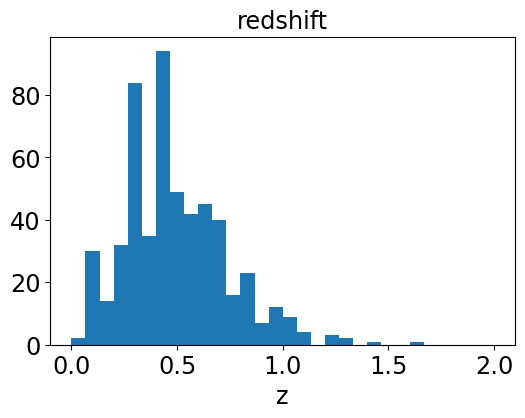

In [19]:
fig,ax = plt.subplots(figsize=(6,4))
ax.hist(arr_z,bins=30,range=(0,2));
ax.set_xlabel("z")
ax.set_title("redshift")

## Check the colors

In [20]:
bwr_map = plt.get_cmap('bwr')
reversed_map = bwr_map.reversed() 
cNorm = colors.Normalize(0., vmax=1.)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=bwr_map)
all_colors = scalarMap.to_rgba(arr_z, alpha=1)

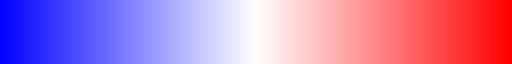

In [21]:
bwr_map

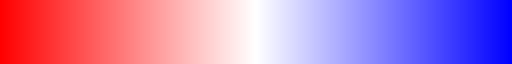

In [22]:
reversed_map

In [23]:
color_z0 = scalarMap.to_rgba(0., alpha=1)

In [24]:
color_z1 = scalarMap.to_rgba(1., alpha=1)

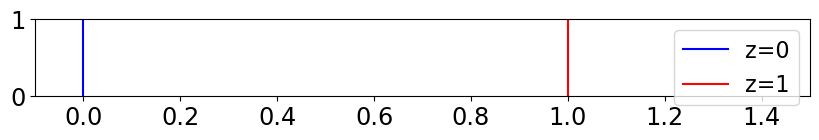

In [25]:
plt.figure(figsize=(10,1))
plt.axvline(0.,color=color_z0,label="z=0")
plt.axvline(1.,color=color_z1,label="z=1")
plt.ylim(0.,1.)
plt.xlim(-0.1,1.5)
plt.legend()

## Decode fitted parameters and plot spectra

for idx in range(N):


In [26]:
all_x = []
all_y_nodust = []
all_y_dust = []
the_ymax= 1e-12
for idx,key_sel in enumerate(list_of_keys_sorted):
    #
    group = hf.get(key_sel)
    z_obs = redshift = group.attrs["redshift"]

    wl_flnu = np.array(group.get("wl_flnu"))
    flnu_model = np.array(group.get("flnu_model"))
    flnu_stelatt = np.array(group.get("flnu_stelatt"))
    flnu_stelunatt = np.array(group.get("flnu_stelunatt"))
    wl_lum = np.array(group.get("wl_lum"))
    lum_stelatt = np.array(group.get("lum_stelatt"))
    lum_stelunatt = np.array(group.get("lum_stelunatt"))

    # fnu in mJy
    # wavelength from nm to Angstrom
    x = wl_flnu*10 # A
    y_nodust = flnu_stelunatt
    y_dust = flnu_model 

    ymax = y_nodust.max()
    the_ymax = max(the_ymax,ymax)
    
    all_x.append(x)
    all_y_nodust.append(y_nodust) 
    all_y_dust.append(y_dust) 

ylim_max = the_ymax*2.
ylim_min = ylim_max/1e10

Text(0.5, 0.98, 'SED-PCIGALES-fit (run 2024-02-05)')

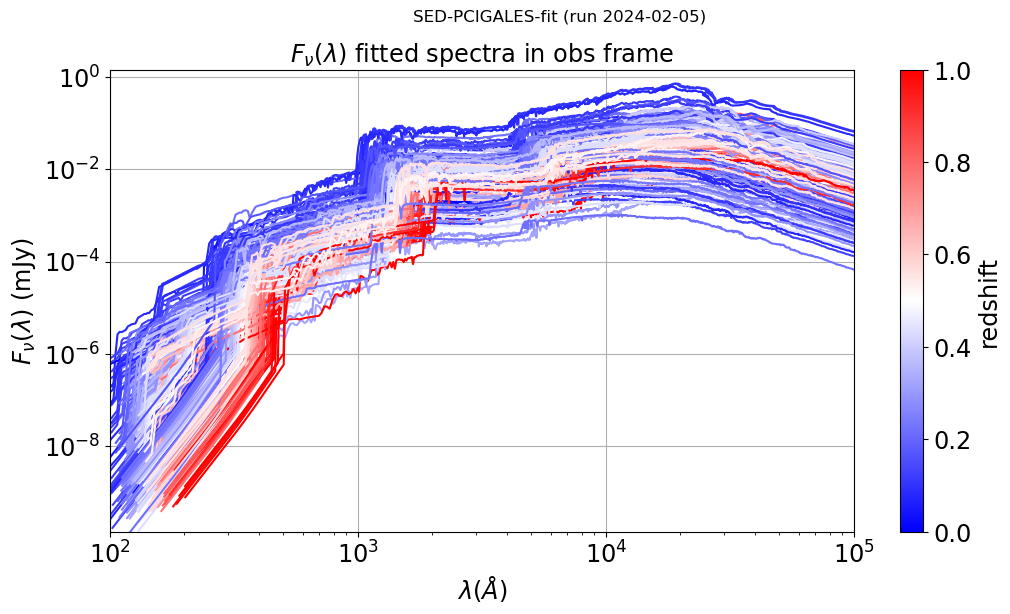

In [27]:
fig, ax = plt.subplots(1, 1)
__= ax.set_yscale('log') 
__= ax.set_xscale('log') 

for idx,key_sel in enumerate(list_of_keys_sorted):
    ax.plot(all_x[idx],all_y_nodust[idx],color=all_colors[idx])
__= ax.set_xlim(100.,1e5)
__= ax.set_ylim(ylim_min ,ylim_max )

cbar=fig.colorbar(scalarMap , ax=ax)
cbar.ax.set_ylabel('redshift')


ax.set_xlabel("$\lambda (\\AA)$")
ax.set_ylabel("$F_\\nu(\lambda)$ (mJy)")
ax.set_title("$F_\\nu(\lambda)$ fitted spectra in obs frame")
ax.grid()
plt.suptitle(suptitle)

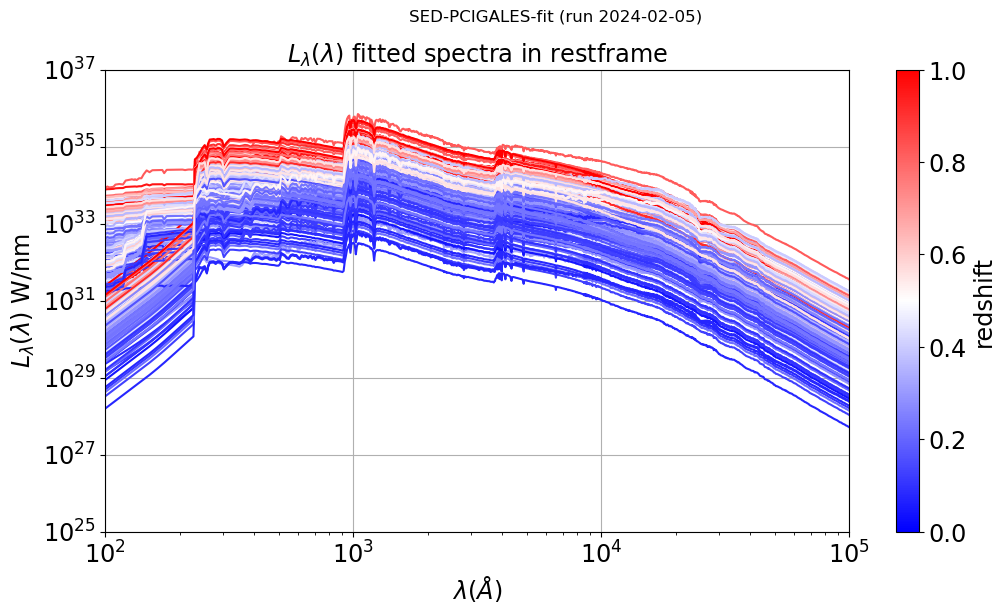

In [28]:
fig, ax = plt.subplots(1, 1)
__= ax.set_yscale('log') 
__= ax.set_xscale('log') 

all_D4000 = []

for idx,key_sel in enumerate(list_of_keys_sorted):

    group = hf.get(key_sel)
    z_obs = redshift = group.attrs["redshift"]

    wl_flnu = np.array(group.get("wl_flnu"))
    flnu_model = np.array(group.get("flnu_model"))
    flnu_stelatt = np.array(group.get("flnu_stelatt"))
    flnu_stelunatt = np.array(group.get("flnu_stelunatt"))
    wl_lum = np.array(group.get("wl_lum"))
    lum_stelatt = np.array(group.get("lum_stelatt"))
    lum_stelunatt = np.array(group.get("lum_stelunatt"))

    # L_lambda in W/nm
    # wavelength from nm to Angstrom
    x = wl_lum*10 # A
    y_nodust = lum_stelunatt
    y_dust = lum_stelatt 

    D4000 = calc_ratio(x,y_nodust)
    all_D4000.append(D4000) 
    
    ax.plot(x,y_nodust,color=all_colors[idx])
__= ax.set_xlim(100.,1e5)
__= ax.set_ylim(1e25 ,1e37 )


cbar=fig.colorbar(scalarMap , ax=ax)
cbar.ax.set_ylabel('redshift')

ax.set_xlabel("$\lambda (\\AA)$")
ax.set_ylabel("$L_\\lambda(\lambda)$ W/nm")
ax.set_title("$L_\\lambda(\lambda)$ fitted spectra in restframe")
ax.grid()
plt.suptitle(suptitle)
all_D4000 = np.array(all_D4000)

Text(0.5, 1.0, 'D4000')

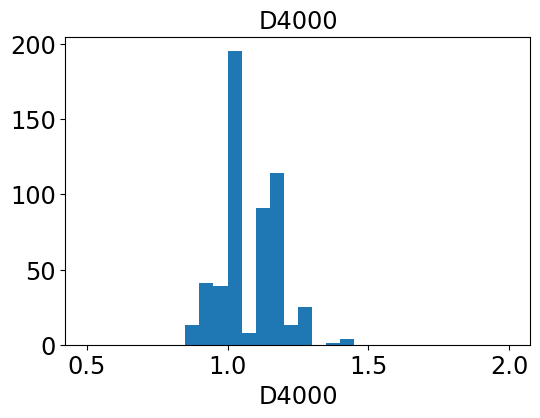

In [29]:
fig,ax = plt.subplots(figsize=(6,4))
ax.hist(all_D4000,bins=30,range=(0.5,2));
ax.set_xlabel("D4000")
ax.set_title("D4000")

## Plot normalized spectra

In [30]:
all_x = []
all_y_nodust = []
all_y_dust = []
the_ymax= 1e-12
all_t = []
all_sfh = []

for idx,key_sel in enumerate(list_of_keys_sorted):

    group = hf.get(key_sel)
    z_obs = redshift = group.attrs["redshift"]

    wl_flnu = np.array(group.get("wl_flnu"))
    flnu_model = np.array(group.get("flnu_model"))
    flnu_stelatt = np.array(group.get("flnu_stelatt"))
    flnu_stelunatt = np.array(group.get("flnu_stelunatt"))
    wl_lum = np.array(group.get("wl_lum"))
    lum_stelatt = np.array(group.get("lum_stelatt"))
    lum_stelunatt = np.array(group.get("lum_stelunatt"))

    # fnu
    # set wavelength from nm to Angstrom, but in rest frame
    x = wl_lum*10  # A
    y_nodust = lum_stelunatt
    y_dust = lum_stelatt 
    
    
    norm_y_nodust = flux_norm(x,y_nodust,wlcenter=wl0)
    norm_y_dust = flux_norm(x,y_dust,wlcenter=wl0)

    y_nodust /=  norm_y_nodust
    y_dust /=  norm_y_dust

     
    all_x.append(x)
    all_y_nodust.append(y_nodust) 
    all_y_dust.append(y_dust) 

ylim_max = the_ymax*2.
ylim_min = ylim_max/1e10

Text(0.5, 0.98, 'SED-PCIGALES-fit (run 2024-02-05)')

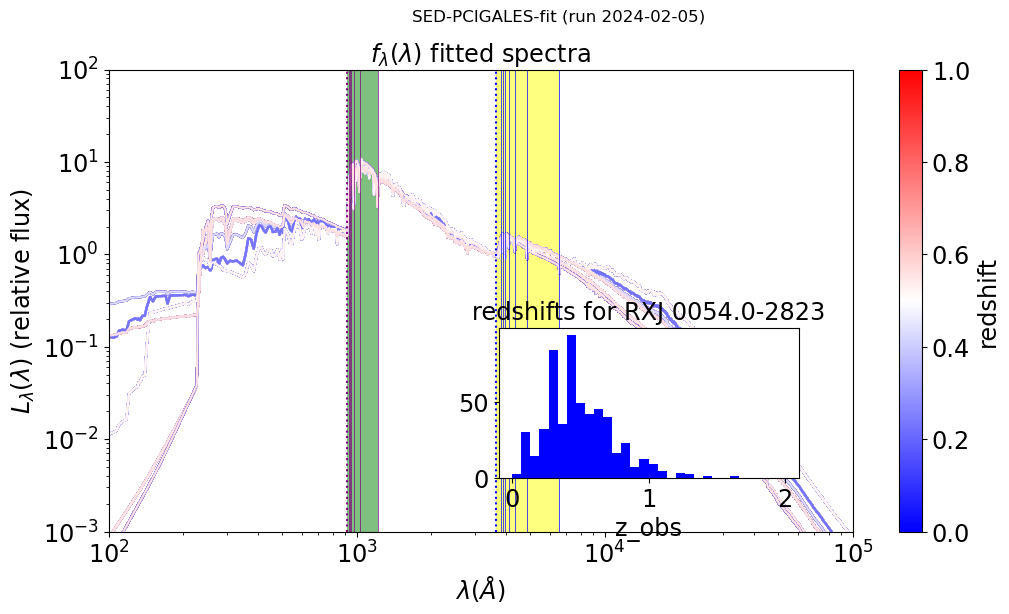

In [31]:
fig, ax = plt.subplots(1, 1)
__= ax.set_yscale('log') 
__= ax.set_xscale('log') 

for idx,key_sel in enumerate(list_of_keys_sorted):

    group = hf.get(key_sel)
    z_obs = redshift = group.attrs["redshift"]

    wl_flnu = np.array(group.get("wl_flnu"))
    flnu_model = np.array(group.get("flnu_model"))
    flnu_stelatt = np.array(group.get("flnu_stelatt"))
    flnu_stelunatt = np.array(group.get("flnu_stelunatt"))
    wl_lum = np.array(group.get("wl_lum"))
    lum_stelatt = np.array(group.get("lum_stelatt"))
    lum_stelunatt = np.array(group.get("lum_stelunatt"))

    # flambda
    # set wavelength from nm to Angstrom, but in rest frame
    x = wl_lum*10  # A
    y_nodust = lum_stelunatt
    y_dust = lum_stelatt 
    
    
    norm_y_nodust = flux_norm(x,y_nodust,wlcenter=wl0)
    norm_y_dust = flux_norm(x,y_dust,wlcenter=wl0)

    y_nodust /=  norm_y_nodust
    y_dust /=  norm_y_dust

   
    ax.plot(x,y_nodust,color=all_colors[idx])
__= ax.set_xlim(100.,1e5)
#__= ax.set_ylim(ylim_min ,ylim_max )
ax.set_ylim(1e-3,1e2)


cbar=fig.colorbar(scalarMap , ax=ax)
cbar.ax.set_ylabel('redshift')

ax.set_xlabel("$\lambda (\\AA)$")
ax.set_ylabel("$L_\\lambda(\lambda)$ (relative flux)")
ax.set_title("$f_\\lambda(\lambda)$ fitted spectra")
#ax.grid()
plot_hydrogen_lines(ax)


left, bottom, width, height = [0.45, 0.2, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.hist(arr_z,bins=30,range=(0,2),facecolor="b")
ax2.set_xlabel("z_obs")
ax2.set_title("redshifts for RXJ 0054.0-2823")
#df["zobs"].plot(kind='hist', bins=30,range=(0,1.5),facecolor="b",xlabel="z_obs",
#                title="redshifts for RXJ 0054.0-2823",ax=ax2);

plt.suptitle(suptitle)

Text(0.5, 0.98, 'SED-PCIGALES-fit (run 2024-02-05)')

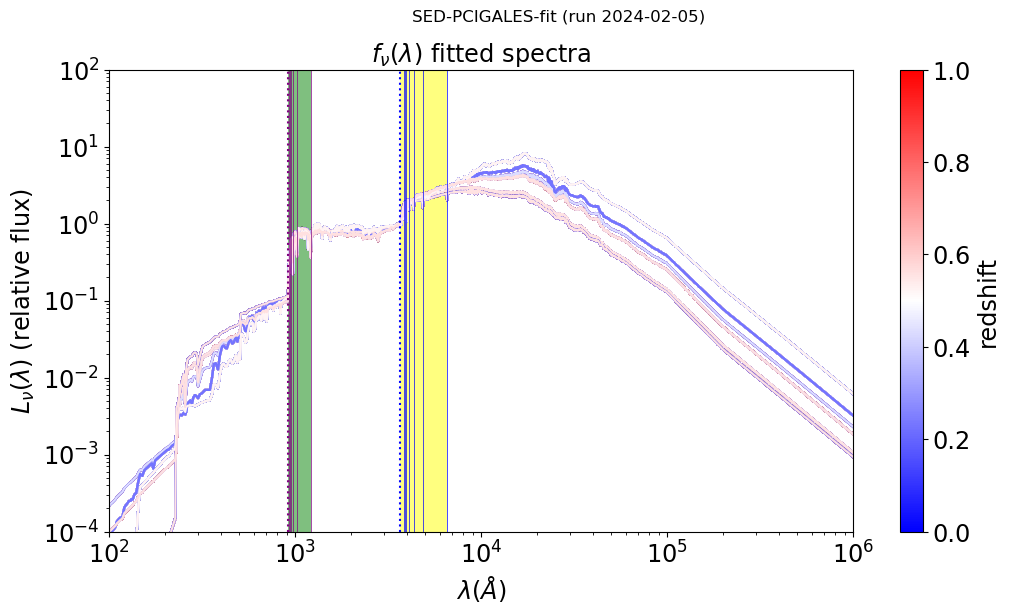

In [32]:
fig, ax = plt.subplots(1, 1)
__= ax.set_yscale('log') 
__= ax.set_xscale('log') 

for idx,key_sel in enumerate(list_of_keys_sorted):

    group = hf.get(key_sel)
    z_obs = redshift = group.attrs["redshift"]


    wl_flnu = np.array(group.get("wl_flnu"))
    flnu_model = np.array(group.get("flnu_model"))
    flnu_stelatt = np.array(group.get("flnu_stelatt"))
    flnu_stelunatt = np.array(group.get("flnu_stelunatt"))
    wl_lum = np.array(group.get("wl_lum"))
    lum_stelatt = np.array(group.get("lum_stelatt"))
    lum_stelunatt = np.array(group.get("lum_stelunatt"))

    # flambda
    # set wavelength from nm to Angstrom, but in rest frame
    x = wl_lum*10  # A
    y_nodust = lum_stelunatt*x**2
    y_dust = lum_stelatt*x**2 
    
    
    norm_y_nodust = flux_norm(x,y_nodust,wlcenter=wl0)
    norm_y_dust = flux_norm(x,y_dust,wlcenter=wl0)

    y_nodust /=  norm_y_nodust
    y_dust /=  norm_y_dust

   
    ax.plot(x,y_nodust,color=all_colors[idx])
__= ax.set_xlim(100.,1e6)
#__= ax.set_ylim(ylim_min ,ylim_max )
ax.set_ylim(1e-4,1e2)


cbar=fig.colorbar(scalarMap , ax=ax)
cbar.ax.set_ylabel('redshift')

ax.set_xlabel("$\lambda (\\AA)$")
ax.set_ylabel("$L_\\nu(\lambda)$ (relative flux)")
ax.set_title("$f_\\nu(\lambda)$ fitted spectra")
#ax.grid()
plot_hydrogen_lines(ax)

#INSET
#left, bottom, width, height = [0.45, 0.2, 0.25, 0.25]
#ax2 = fig.add_axes([left, bottom, width, height])
#ax2.hist(arr_z,bins=30,range=(0,2),facecolor="b")
#ax2.set_xlabel("z_obs")
#ax2.set_title("redshifts for RXJ 0054.0-2823")

plt.suptitle(suptitle)

## D4000

In [33]:
bwr_map = plt.get_cmap('bwr')
reversed_map = bwr_map.reversed() 
#cNorm = colors.Normalize(vmin=np.log10(all_fractions).min(), vmax=np.log10(all_fractions).max())
#scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=reversed_map)
#all_colors = scalarMap.to_rgba(np.log10(all_fractions), alpha=1)
cNorm = colors.Normalize(vmin=D4000MIN, vmax=D4000MAX)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=bwr_map)
all_colors = scalarMap.to_rgba(all_D4000, alpha=1)

Text(0.5, 0.98, 'SED-PCIGALES-fit (run 2024-02-05)')

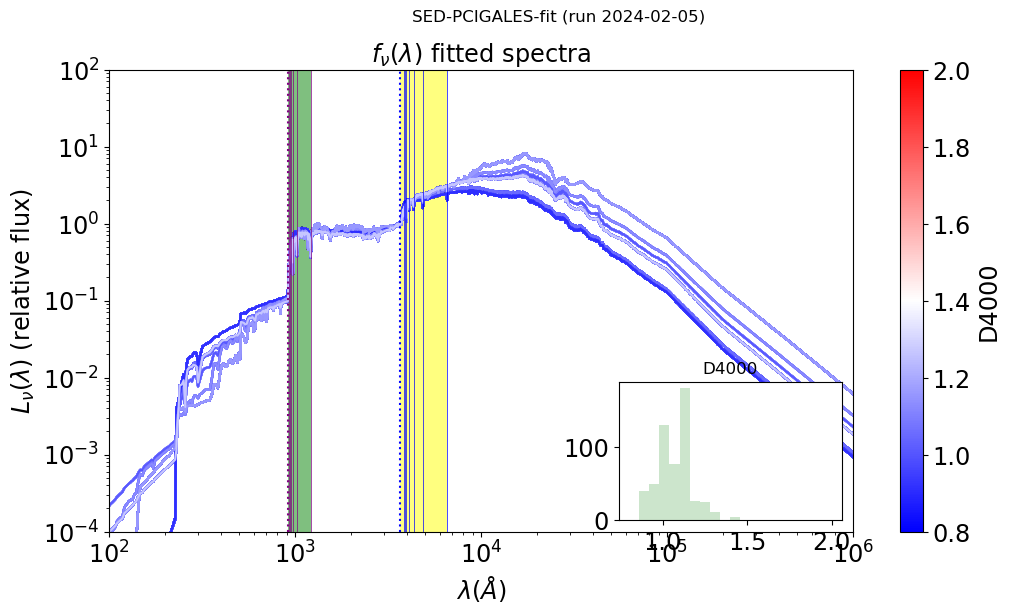

In [34]:
fig, ax = plt.subplots(1, 1)
__= ax.set_yscale('log') 
__= ax.set_xscale('log') 

for idx,key_sel in enumerate(list_of_keys_sorted):

    group = hf.get(key_sel)
    z_obs = redshift = group.attrs["redshift"]


    wl_flnu = np.array(group.get("wl_flnu"))
    flnu_model = np.array(group.get("flnu_model"))
    flnu_stelatt = np.array(group.get("flnu_stelatt"))
    flnu_stelunatt = np.array(group.get("flnu_stelunatt"))
    wl_lum = np.array(group.get("wl_lum"))
    lum_stelatt = np.array(group.get("lum_stelatt"))
    lum_stelunatt = np.array(group.get("lum_stelunatt"))

     # flambda
    # set wavelength from nm to Angstrom, but in rest frame
    x = wl_lum*10  # A
    y_nodust = lum_stelunatt*x**2
    y_dust = lum_stelatt*x**2 
    
    
    norm_y_nodust = flux_norm(x,y_nodust,wlcenter=wl0)
    norm_y_dust = flux_norm(x,y_dust,wlcenter=wl0)

    y_nodust /=  norm_y_nodust
    y_dust /=  norm_y_dust

    ax.plot(x,y_nodust,color=all_colors[idx])



__= ax.set_xlim(100.,1e6)
#__= ax.set_ylim(ylim_min ,ylim_max )
ax.set_ylim(1e-4,1e2)


cbar=fig.colorbar(scalarMap , ax=ax)
cbar.ax.set_ylabel('D4000')

ax.set_xlabel("$\lambda (\\AA)$")
ax.set_ylabel("$L_\\nu(\lambda)$ (relative flux)")
ax.set_title("$f_\\nu(\lambda)$ fitted spectra")
#ax.grid()
plot_hydrogen_lines(ax)

#INSET
#left, bottom, width, height = [0.45, 0.2, 0.25, 0.25]
#ax2 = fig.add_axes([left, bottom, width, height])
#ax2.hist(arr_z,bins=30,range=(0,2),facecolor="b")
#ax2.set_xlabel("z_obs")
#ax2.set_title("redshifts for RXJ 0054.0-2823")

inset_ax = inset_axes(ax,
                    width="30%", # width = 30% of parent_bbox
                    height="30%", # height : 1 inch
                    loc=4)
inset_ax.hist(all_D4000,bins=20,range=(D4000MIN,D4000MAX),facecolor="g",alpha=0.2)
inset_ax.set_title("D4000",fontsize=12)

plt.suptitle(suptitle)

## Plot Filters of LSST

In [35]:
ps = FilterInfo()
ps.dump()

filters_indexlist   : 	  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
filters_surveylist  : 	  ['galex', 'galex', 'sdss', 'sdss', 'sdss', 'sdss', 'vircam', 'vircam', 'vircam', 'vircam', 'vircam']
filters__namelist   : 	  ['galex_FUV', 'galex_NUV', 'sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'vista_vircam_Z', 'vista_vircam_Y', 'vista_vircam_J', 'vista_vircam_H', 'vista_vircam_Ks']


/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_96948/1028603930.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_96948/1028603930.py:99: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

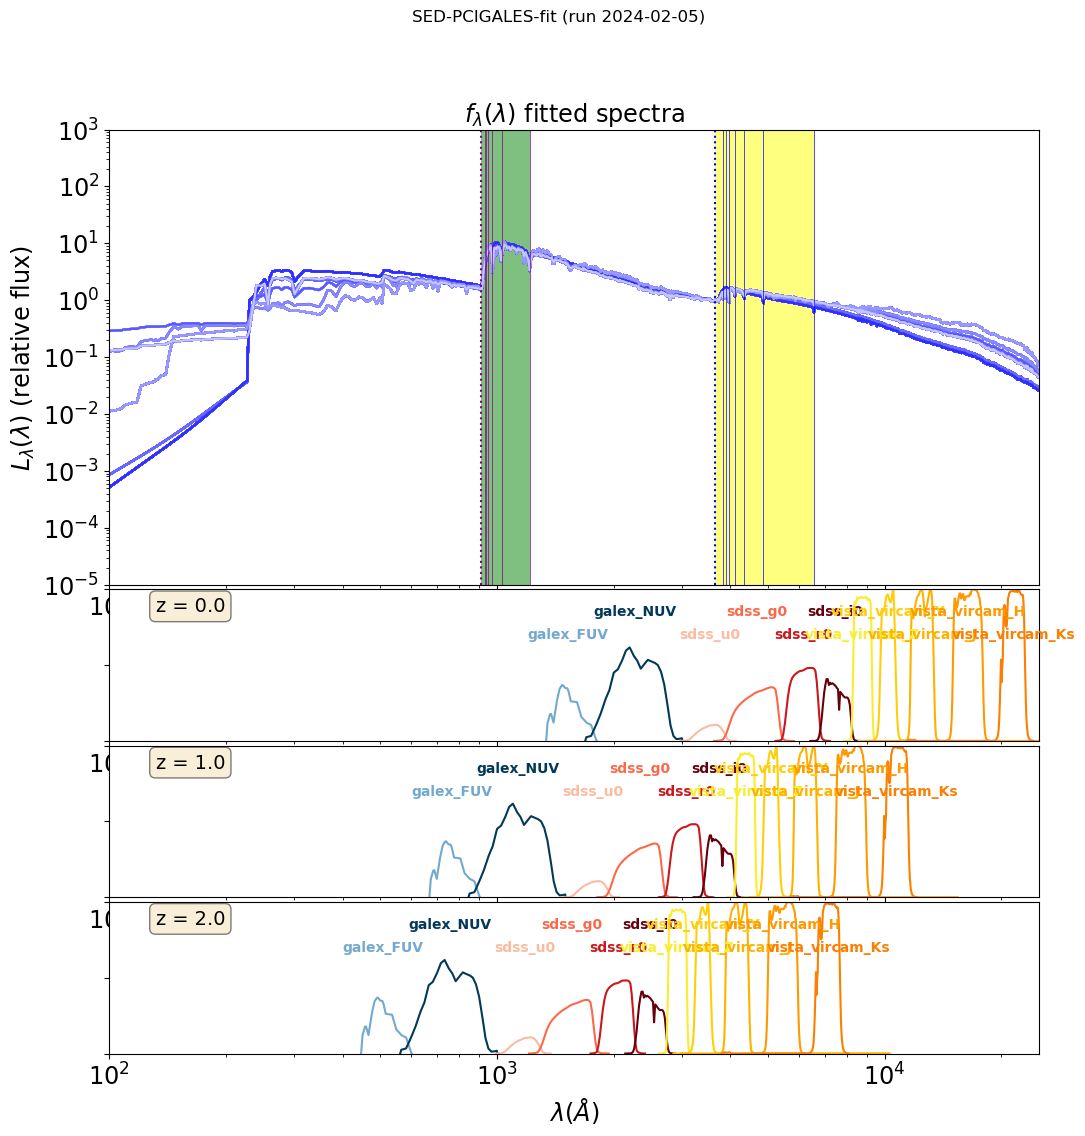

In [36]:
plt.suptitle(suptitle)#fig, axs = plt.subplots(4, 1,figsize=(12,12),sharex=True)

fig = plt.figure(constrained_layout=True,figsize=(12,12))

gs = gridspec.GridSpec(nrows=4, ncols=1, height_ratios=[3,1,1,1],hspace=0.02)
#fig.subplots_adjust(left=0.05, bottom=0.06, right=0.95, top=0.94, wspace=0.2)         

ax = fig.add_subplot(gs[0])

for idx,key_sel in enumerate(list_of_keys_sorted):

    group = hf.get(key_sel)
    z_obs = redshift = group.attrs["redshift"]

    wl_flnu = np.array(group.get("wl_flnu"))
    flnu_model = np.array(group.get("flnu_model"))
    flnu_stelatt = np.array(group.get("flnu_stelatt"))
    flnu_stelunatt = np.array(group.get("flnu_stelunatt"))
    wl_lum = np.array(group.get("wl_lum"))
    lum_stelatt = np.array(group.get("lum_stelatt"))
    lum_stelunatt = np.array(group.get("lum_stelunatt"))

    # flambda
    # set wavelength from nm to Angstrom, but in rest frame
    x = wl_lum*10  # A
    y_nodust = lum_stelunatt
    y_dust = lum_stelatt 
    
    
    norm_y_nodust = flux_norm(x,y_nodust,wlcenter=wl0)
    norm_y_dust = flux_norm(x,y_dust,wlcenter=wl0)

    y_nodust /=  norm_y_nodust
    y_dust /=  norm_y_dust

   
   
    ax.plot(x,y_nodust,color=all_colors[idx])
__= ax.set_xlim(100.,2.5e4)
#__= ax.set_ylim(ylim_min ,ylim_max )


#cbar=fig.colorbar(scalarMap , ax=ax)
#cbar.ax.set_ylabel('redshift')

__= ax.set_yscale('log') 
__= ax.set_xscale('log') 

ax.set_xlabel("$\lambda (\\AA)$")
ax.set_ylabel("$L_\\lambda(\lambda)$ (relative flux)")
ax.set_title("$f_\\lambda(\lambda)$ fitted spectra")
ax.set_ylim(1e-5,1e3)
plot_hydrogen_lines(ax)

# INSET
#inset_ax = inset_axes(ax,
#                    width="30%", # width = 30% of parent_bbox
#                    height="30%", # height : 1 inch
#                    loc=2)
#df["zobs"].plot(kind='hist', bins=30,range=(0,1.5),facecolor="b",xlabel="z_obs",ylabel="",
#                title="redshifts for RXJ 0054.0-2823",ax=inset_ax);

#left, bottom, width, height = [0.45, 0.2, 0.25, 0.25]
#ax2 = fig.add_axes([left, bottom, width, height])
#df["zobs"].plot(kind='hist', bins=30,range=(0,1.5),facecolor="b",xlabel="z_obs",
#                title="redshifts for RXJ 0054.0-2823",ax=ax2);

# loop on redshift
for idx,redshift in enumerate([0.,1.,2.]):

    textstr = f"z = {redshift:.1f}"
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    
    ax3 = fig.add_subplot(gs[1+idx], sharex=ax)
    plt.setp(ax3.get_yticklabels(), visible=False)
    ax3.text(0.05, 0.95, textstr, transform=ax3.transAxes, fontsize=14,verticalalignment='top', bbox=props)

    
    
    # loop on filters
    for index in ps.filters_indexlist:
        the_name = ps.filters_namelist[index]
        the_filt = ps.filters_transmissionlist[index]
        the_norm = ps.filters_transmissionnormlist[index]
        the_wlmean = the_filt.wave_mean
        the_color = ps.filters_colorlist[index]
        the_transmission =the_filt.transmission/the_norm
        ax3.plot(the_filt.wavelength/(1+redshift),the_transmission,color=the_color)

        if index%2 ==0:
            ax3.text(the_wlmean/(1+redshift), 0.7, the_name,horizontalalignment='center',verticalalignment='center',color=the_color,fontweight="bold")
        else:
            ax3.text(the_wlmean/(1+redshift), 0.85, the_name,horizontalalignment='center',verticalalignment='center',color=the_color,fontweight="bold")
   
    __=ax3.set_ylim(0.,1.)
    ax3.set_xlabel("$\lambda (\\AA)$")

plt.suptitle(suptitle)
plt.tight_layout()